In [12]:
import numpy as np
import pandas as pd
import scipy as sc
import scipy.stats as st
from matplotlib import pyplot as plt
from sklearn.metrics import mean_squared_error
from sklearn.model_selection import train_test_split

In [13]:
file2 = pd.read_csv("Output/BenSummaryNew.csv")
#Extract useful data
#file2 = file2[file2['Target PPM'] < 100]
xDataResistance = file2.loc[:, 'Resistance']
xDataRatio = file2.loc[:, 'Ratio']
xDataRH = file2.loc[:, 'RelativeHumidity']
xDataTemp = file2.loc[:, 'Temperature']
yDataTargetPPM = file2.loc[:, 'Target PPM']
#Train Test split
X = file2.drop('Target PPM', axis='columns')
y = file2.loc[:, 'Target PPM']

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

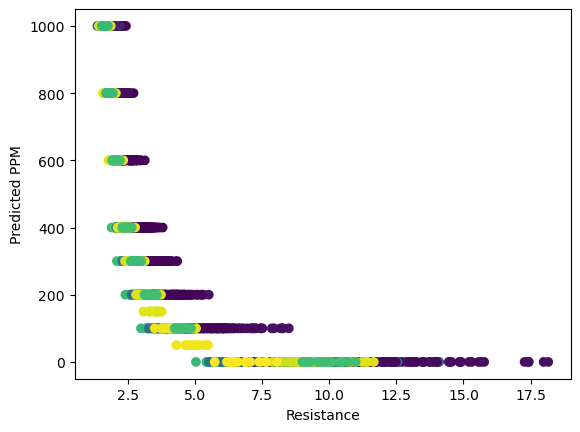

In [14]:
df = file2
plt.scatter(df.loc[:, 'Resistance'], df.loc[:, "Target PPM"], c=xDataRH)
plt.xlabel("Resistance")
plt.ylabel('Predicted PPM')
plt.show()

Accuracy of equation

0-1000
Resistance: RMSE 111.6
Resistance+Humidity: RMSE 88.1
Resistance+Temperature: RMSE 111.3
Resistance+Humidity+Temperature: RMSE: 87.6
0-500
Resistance: RMSE 60.7
Resistance+Humidity: RMSE 47.9
Resistance+Temperature: RMSE 60.7
Resistance+Humidity+Temperature: RMSE: 44.3

In [15]:
# Funk Equation
def funct3(X, a, b, c, d, e,f,g,h,i,j):
    R, H, T = X
    return a * np.exp(-1 * R*b + c) + d * np.exp(-1 * H*e + f) + g * np.exp(-1 * T*h + i) +j
p0 = 1,1,.5,1,1,1,1,1,1,1
# Perform curve fitting using the funct function, xDataResistance, and yDataTargetPPM data
# Set the maximum number of function evaluations to 1000000
popt, pcov = sc.optimize.curve_fit(funct3, (xDataResistance,xDataRH, xDataTemp), yDataTargetPPM,p0, maxfev=1000000)

# Print the optimized parameters
print(popt)

# Extract the Resistance column from the X_test dataframe
R_test = X_test.loc[:, 'Resistance']
H_test = X_test.loc[:, 'RelativeHumidity']
T_test = X_test.loc[:, 'Temperature']

# Generate the predictions using the optimized parameters and the input data
y_pred = funct3((R_test,H_test, T_test), *popt)

# Calculate the mean squared error
testVal = mean_squared_error(y_test, y_pred, squared=False)
print(testVal)

# Iterate through target PPM values and calculate the 95% confidence interval for each value
for i in range(0, 1001, 200):
    # Filter the data for the current target PPM value
    df = file2[file2['Target PPM'] == i]

    # Calculate the model output using the filtered data and optimized parameters
    myData = funct3((df.loc[:, 'Resistance'],df.loc[:, 'RelativeHumidity'], df.loc[:, 'Temperature']), *popt)

    # Calculate the 95% confidence interval using the t-distribution
    low95, high95 = st.t.interval(alpha=0.95, df=len(myData), loc=np.mean(myData), scale=st.sem(myData))

    # Print the 95% confidence interval for the current target PPM value
    print("The 95% Confidence Interval for " + str(i) + " is (" + str(low95) + ", " + str(high95) + ")")

[ 36.64766014   0.91746134   4.79488574   4.3857078    0.08616652
   4.9648357    0.33838881   0.09292548   5.01776706 -70.72306518]
80.36893473048511
The 95% Confidence Interval for 0 is (3.8931600872024186, 18.505941113121427)
The 95% Confidence Interval for 200 is (206.5444166767263, 218.41514299926234)
The 95% Confidence Interval for 400 is (433.8673168374362, 451.12354839489774)
The 95% Confidence Interval for 600 is (584.4706222327412, 607.1799701630033)
The 95% Confidence Interval for 800 is (741.5430013257102, 767.6567677389136)
The 95% Confidence Interval for 1000 is (895.0352161106794, 926.7345597422013)


/var/folders/1g/qs1wt1d52t1fp_9wj2_z6vlr0000gn/T/ipykernel_6724/938967646.py:4: RuntimeWarning: overflow encountered in exp
  return a * np.exp(-1 * R*b + c) + d * np.exp(-1 * H*e + f) + g * np.exp(-1 * T*h + i) +j
/var/folders/1g/qs1wt1d52t1fp_9wj2_z6vlr0000gn/T/ipykernel_6724/938967646.py:4: RuntimeWarning: overflow encountered in multiply
  return a * np.exp(-1 * R*b + c) + d * np.exp(-1 * H*e + f) + g * np.exp(-1 * T*h + i) +j
/var/folders/1g/qs1wt1d52t1fp_9wj2_z6vlr0000gn/T/ipykernel_6724/938967646.py:34: DeprecationWarning: Use of keyword argument 'alpha' for method 'interval' is deprecated and wil be removed in SciPy 1.11.0. Use first positional argument or keyword argument 'confidence' instead.
  low95, high95 = st.t.interval(alpha=0.95, df=len(myData), loc=np.mean(myData), scale=st.sem(myData))


R-squared:  0.922962512972427


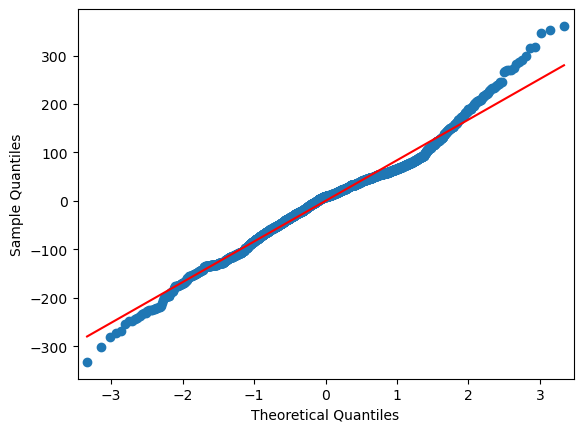

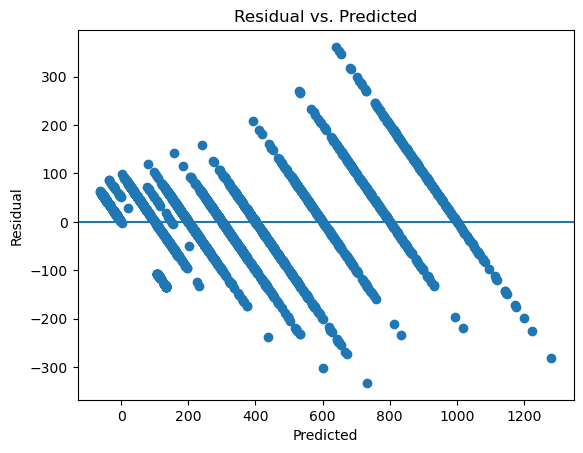

F-statistic: 3117.642662299314
p-value: 0.0


In [16]:
from sklearn.metrics import r2_score
import scipy.stats as stats
from scipy.stats import f
import statsmodels.api as sm
import matplotlib.pyplot as plt
from statsmodels.compat import lzip
import statsmodels.stats.api as sms
from statsmodels.stats.stattools import durbin_watson

y_pred = funct3((xDataResistance,xDataRH, xDataTemp), *popt)
print('R-squared: ', r2_score(y, y_pred))

# Calculate residuals
residuals = y - y_pred

# Reshape your input data to fit the het_breuschpagan function requirements
exog = np.vstack((xDataResistance, xDataRH, xDataTemp)).T

# QQ Plot
sm.qqplot(residuals, line='s')
plt.show()

# Residual vs. Predicted plot
plt.scatter(y_pred, residuals)
plt.xlabel('Predicted')
plt.ylabel('Residual')
plt.axhline(y=0)
plt.title('Residual vs. Predicted')
plt.show()

# First compute the various sum of squares
SST = np.sum((yDataTargetPPM - np.mean(yDataTargetPPM)) ** 2)
SSE = np.sum(residuals ** 2)
SSR = SST - SSE

# Then compute the degree of freedoms
df1 = len(popt) - 1  # number of parameters in your model - 1
df2 = len(yDataTargetPPM) - len(popt)  # number of observations - number of parameters

# Then compute the mean square values
MSR = SSR / df1
MSE = SSE / df2

# Finally compute the F-statistic and the associated p-value
F = MSR / MSE
p_value = f.sf(F, df1, df2)

print('F-statistic:', F)
print('p-value:', p_value)


In [30]:
def funct(X, a, b, c, d,e, f,g):
    R, H, T = X
    return a*R**b+c*H**d+e*(T+30)**f+g
p0 = 1,1,.5,1,1,1,1
# Perform curve fitting using the funct function, xDataResistance, and yDataTargetPPM data
# Set the maximum number of function evaluations to 1000000
popt, pcov = sc.optimize.curve_fit(funct, (xDataRatio,xDataRH, xDataTemp), yDataTargetPPM, maxfev=1000000)

# Print the optimized parameters
print(popt)

# Extract the Resistance column from the X_test dataframe
R_test = X_test.loc[:, 'Ratio']
H_test = X_test.loc[:, 'RelativeHumidity']
T_test = X_test.loc[:, 'Temperature']

# Generate the predictions using the optimized parameters and the input data
y_pred = funct((R_test,H_test, T_test), *popt)

# Calculate the mean squared error
testVal = mean_squared_error(y_test, y_pred, squared=False)
print(testVal)

# Iterate through target PPM values and calculate the 95% confidence interval for each value
for i in range(0, 1001, 200):
    # Filter the data for the current target PPM value
    df = file2[file2['Target PPM'] == i]

    # Calculate the model output using the filtered data and optimized parameters
    myData = funct((df.loc[:, 'Ratio'],df.loc[:, 'RelativeHumidity'], df.loc[:, 'Temperature']), *popt)

    # Calculate the 95% confidence interval using the t-distribution
    low95, high95 = st.t.interval(alpha=0.95, df=len(myData), loc=np.mean(myData), scale=st.sem(myData))

    # Print the 95% confidence interval for the current target PPM value
    print("The 95% Confidence Interval for " + str(i) + " is (" + str(low95) + ", " + str(high95) + ")")

[ 5.89752787e+02  2.75929369e+02  5.90317216e-08  5.03918906e+00
 -2.66296532e-08  4.75109302e+00  3.42409656e+02]
299.7811235999575
The 95% Confidence Interval for 0 is (347.03446146554177, 350.7568160962496)
The 95% Confidence Interval for 200 is (347.06240057259026, 350.7575985540361)
The 95% Confidence Interval for 400 is (346.93707107870887, 350.4801136370046)
The 95% Confidence Interval for 600 is (350.29085779346633, 356.13055319880357)
The 95% Confidence Interval for 800 is (350.06310908367846, 355.7443518470984)
The 95% Confidence Interval for 1000 is (350.0075323741678, 355.61283310050055)


/Users/benfunk/anaconda3/lib/python3.10/site-packages/scipy/optimize/_minpack_py.py:906: OptimizeWarning: Covariance of the parameters could not be estimated
  warnings.warn('Covariance of the parameters could not be estimated',
/var/folders/1g/qs1wt1d52t1fp_9wj2_z6vlr0000gn/T/ipykernel_6724/4077975347.py:33: DeprecationWarning: Use of keyword argument 'alpha' for method 'interval' is deprecated and wil be removed in SciPy 1.11.0. Use first positional argument or keyword argument 'confidence' instead.
  low95, high95 = st.t.interval(alpha=0.95, df=len(myData), loc=np.mean(myData), scale=st.sem(myData))


R-squared:  0.003722715446507152


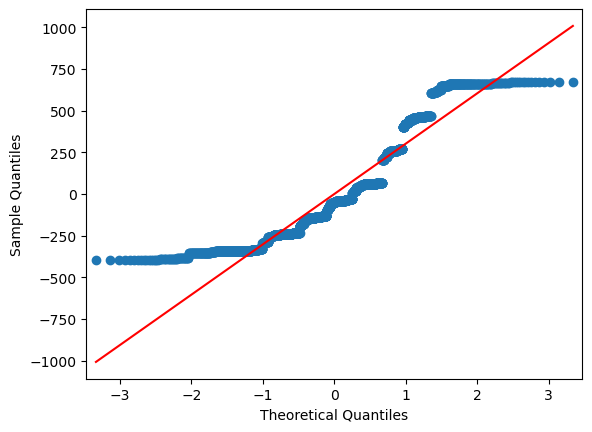

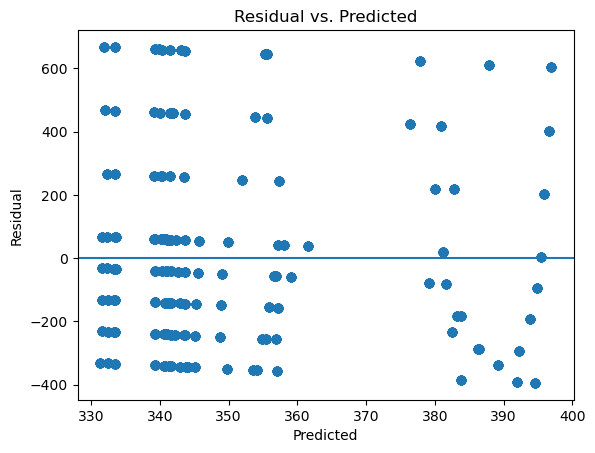

F-statistic: 1.4603979329529424
p-value: 0.1879222545490937


In [31]:
y_pred = funct((xDataRatio,xDataRH, xDataTemp), *popt)
print('R-squared: ', r2_score(y, y_pred))

# Calculate residuals
residuals = y - y_pred

# Reshape your input data to fit the het_breuschpagan function requirements
exog = np.vstack((xDataRatio, xDataRH, xDataTemp)).T

# QQ Plot
sm.qqplot(residuals, line='s')
plt.show()

# Residual vs. Predicted plot
plt.scatter(y_pred, residuals)
plt.xlabel('Predicted')
plt.ylabel('Residual')
plt.axhline(y=0)
plt.title('Residual vs. Predicted')
plt.show()

# First compute the various sum of squares
SST = np.sum((yDataTargetPPM - np.mean(yDataTargetPPM)) ** 2)
SSE = np.sum(residuals ** 2)
SSR = SST - SSE

# Then compute the degree of freedoms
df1 = len(popt) - 1  # number of parameters in your model - 1
df2 = len(yDataTargetPPM) - len(popt)  # number of observations - number of parameters

# Then compute the mean square values
MSR = SSR / df1
MSE = SSE / df2

# Finally compute the F-statistic and the associated p-value
F = MSR / MSE
p_value = f.sf(F, df1, df2)

print('F-statistic:', F)
print('p-value:', p_value)